In [1]:
!pip install --quiet --pre dgl-cu101
!pip install --quiet torch==1.6.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.8.2 requires torch==1.7.1, but you have torch 1.6.0 which is incompatible.
allennlp 0.9.0 requires spacy<2.2,>=2.1.0, but you have spacy 2.2.3 which is incompatible.


In [2]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import dgl.function as fn
from dgl.ops import edge_softmax

from functools import partial
import seaborn as sns
import pickle
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
import tsne_func
print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.6a210111


In [3]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [4]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/CAP_wihtout_zipcode/"
start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph'), 'rb') as f:
    G, node_labels = pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 8.3599 seconds to load graph


In [5]:
utils.graph_show(G)

**************************************************
Node_types:  ['usaanr']
Edge_types:  ['AUTO_RELATED', 'Brother_Sister', 'Busi_rel_Other', 'Child', 'Ex-Spouse', 'Parent', 'Pers_rel_Other', 'SPONSEE', 'SPONSOR', 'Spouse', 'Step-Child', 'Step-Parent']
**************************************************
Canonical Etypes of Graph is:

usaanr              AUTO_RELATED        usaanr              
usaanr              Brother_Sister      usaanr              
usaanr              Busi_rel_Other      usaanr              
usaanr              Child               usaanr              
usaanr              Ex-Spouse           usaanr              
usaanr              Parent              usaanr              
usaanr              Pers_rel_Other      usaanr              
usaanr              SPONSEE             usaanr              
usaanr              SPONSOR             usaanr              
usaanr              Spouse              usaanr              
usaanr              Step-Child          usaanr          

In [6]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)
usaanr_feat=[x for x in usaanr_feat if x not in ['ZIPCD','train_mask','val_mask','test_mask']]

print()
print("The features associated with USAA Member are\n ")
for i in usaanr_feat:
    print(i)


The features associated with USAA Member are
 
usaayr
AGE_BAND
ORIGEL
ELIG2
cmpyelig
SEX
MARST
BRANCH
ENLPAYGD
MILST
MLIST_OrigStat
ACTCORP
STATE
Segment


In [7]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.G=G.to(device)
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(G.nodes['usaanr'].data[col].max().item()+1, feature_size)
    
    def forward(self,nid):
        nid=nid.to(device)
        extra_repr=[]
        for i,col in enumerate(usaanr_feat):
            ndata=self.G.nodes['usaanr'].data[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)


class HGTLayer(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 node_dict,
                 edge_dict,
                 n_heads,
                 dropout = 0.2,
                 use_norm = False):
        super(HGTLayer, self).__init__()

        self.in_dim        = in_dim
        self.out_dim       = out_dim
        self.node_dict     = node_dict
        self.edge_dict     = edge_dict
        self.num_types     = len(node_dict)
        self.num_relations = len(edge_dict)
        self.total_rel     = self.num_types * self.num_relations * self.num_types
        self.n_heads       = n_heads
        self.d_k           = out_dim // n_heads
        self.sqrt_dk       = math.sqrt(self.d_k)
        self.att           = None

        self.k_linears   = nn.ModuleList()
        self.q_linears   = nn.ModuleList()
        self.v_linears   = nn.ModuleList()
        self.a_linears   = nn.ModuleList()
        self.norms       = nn.ModuleList()
        self.use_norm    = use_norm

        for t in range(self.num_types):
            self.k_linears.append(nn.Linear(in_dim,   out_dim))
            self.q_linears.append(nn.Linear(in_dim,   out_dim))
            self.v_linears.append(nn.Linear(in_dim,   out_dim))
            self.a_linears.append(nn.Linear(out_dim,  out_dim))
            if use_norm:
                self.norms.append(nn.LayerNorm(out_dim))

        self.relation_pri   = nn.Parameter(th.ones(self.num_relations, self.n_heads))
        self.relation_att   = nn.Parameter(th.Tensor(self.num_relations, n_heads, self.d_k, self.d_k))
        self.relation_msg   = nn.Parameter(th.Tensor(self.num_relations, n_heads, self.d_k, self.d_k))
        self.skip           = nn.Parameter(th.ones(self.num_types))
        self.drop           = nn.Dropout(dropout)

        nn.init.xavier_uniform_(self.relation_att)
        nn.init.xavier_uniform_(self.relation_msg)

    def forward(self, sg, h):
        with sg.local_scope():
            node_dict, edge_dict = self.node_dict, self.edge_dict
            
            #### remove the edges where the number of edges==0
#             etypes_with_nonzero_edges = [etype for etype in sg.etypes if sg.num_edges(etype) > 0]
#             sg=sg.edge_type_subgraph(etypes_with_nonzero_edges)
            
            for srctype, etype, dsttype in sg.canonical_etypes:
                sub_graph = sg[srctype, etype, dsttype]

                if sub_graph.num_edges()==0:
                    sub_graph.edata['t'] = th.zeros([sub_graph.num_edges(),self.n_heads,1]).to(device)
                else:
                    k_linear = self.k_linears[node_dict[srctype]]
                    v_linear = self.v_linears[node_dict[srctype]]
                    q_linear = self.q_linears[node_dict[dsttype]]

                    k = k_linear(h[srctype]).view(-1, self.n_heads, self.d_k)
                    v = v_linear(h[srctype]).view(-1, self.n_heads, self.d_k)
                    q = q_linear(h[dsttype][0:sg.num_dst_nodes()]).view(-1, self.n_heads, self.d_k)

                    e_id = self.edge_dict[etype]

                    relation_att = self.relation_att[e_id]
                    relation_pri = self.relation_pri[e_id]
                    relation_msg = self.relation_msg[e_id]

                    k = th.einsum("bij,ijk->bik", k, relation_att)
                    v = th.einsum("bij,ijk->bik", v, relation_msg)

                    sub_graph.srcdata['k'] = k
                    sub_graph.dstdata['q'] = q
                    sub_graph.srcdata['v'] = v

                    sub_graph.apply_edges(fn.v_dot_u('q', 'k', 't'))
                    attn_score = sub_graph.edata.pop('t').sum(-1) * relation_pri / self.sqrt_dk
                    attn_score = edge_softmax(sub_graph, attn_score, norm_by='dst')

                    sub_graph.edata['t'] = attn_score.unsqueeze(-1)
                    
#                     if 't' not in list(sub_graph.edata.keys()): 
#                         sub_graph.edata['t'] = th.zeros([sub_graph.num_edges(),self.n_heads,1])

#             for etype in sg.etypes:
#                 if 't' not in list(sg.edges[etype].data.keys()): 
#                     sg.edges[etype].data['t'] = th.zeros([sg.num_edges(etype),self.n_heads,1])
        
            sg.multi_update_all({etype : (fn.u_mul_e('v', 't', 'm'), fn.sum('m', 't')) \
                                for etype in edge_dict}, cross_reducer = 'mean')

            new_h = {}
            for ntype in sg.ntypes:
                '''
                    Step 3: Target-specific Aggregation
                    x = norm( W[node_type] * gelu( Agg(x) ) + x )
                '''
                n_id = node_dict[ntype]
                alpha = th.sigmoid(self.skip[n_id])
                t = sg.dstnodes[ntype].data['t'].view(-1, self.out_dim)
                trans_out = self.drop(self.a_linears[n_id](t))
                trans_out = trans_out * alpha + h[ntype][0:sg.num_dst_nodes()] * (1-alpha)
                if self.use_norm:
                    new_h[ntype] = self.norms[n_id](trans_out)
                else:
                    new_h[ntype] = trans_out
            return new_h

class HGT(nn.Module):
    def __init__(self, G, node_dict, edge_dict, in_feat, h_dim, out_feat, n_layers, n_heads, use_norm = True):
        super(HGT, self).__init__()
        self.G=G
        self.node_dict = node_dict
        self.edge_dict = edge_dict
        self.gcs = nn.ModuleList()
        self.in_feat = in_feat
        self.h_dim = h_dim
        self.out_feat = out_feat
        self.n_layers = n_layers
        self.adapt_ws  = nn.ModuleList()
        for t in range(len(node_dict)):
            self.adapt_ws.append(nn.Linear(in_feat,   h_dim))
        for _ in range(n_layers):
            self.gcs.append(HGTLayer(h_dim, h_dim, node_dict, edge_dict, n_heads, use_norm = use_norm))
        self.out = nn.Linear(h_dim, out_feat)
        
        self.node_embed=nn.ModuleDict()
        self.node_embed['usaanr'] = USAANR_Embedding(self.G,self.in_feat)
           
    def forward(self, input_nodes, blocks=None):
        H = {}
        for ntype, nid in input_nodes.items():
            nid = input_nodes[ntype]
            H[ntype] = F.gelu(self.adapt_ws[self.node_dict[ntype]](self.node_embed[ntype](nid)))
        
        if blocks is None:
            for layer in self.gcs:
                H = layer(self.G, H)
        else:
            for layer, block in zip(self.gcs, blocks):
                H = layer(block, H)
        return self.out(H["usaanr"]), H["usaanr"]

In [8]:
def evaluate(model, loader, labels, category, device):
    model.eval()
    total_loss = 0
    total_acc = 0
#     total_precision=0
#     total_recall=0
    total_fscore_macro=0
    total_fscore_micro=0
    total_fscore_weighted=0
#     total_auc=0
#     total_pr_auc=0
    
    count = 0
    count_loss=0
    
    y_pred=[]
    y_true=[]
    
    for input_nodes_raw, seeds_raw, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)

        input_nodes={}
        input_nodes[category]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}

        lbl = labels[seeds].to(device)
        logits,h = model(input_nodes,blocks)
        loss = F.cross_entropy(logits, lbl.squeeze(1).to(device))
#         loss = F.cross_entropy(logits, lbl.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))
        acc = th.sum(logits.argmax(dim=1) == lbl.squeeze(1)).item() / logits.shape[0]
#         precision, recall, fscore, support = score(lbl.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

        precision_macro, recall_macro, fscore_macro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
        precision_micro, recall_micro, fscore_micro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
        precision_weighted, recall_weighted, fscore_weighted, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')
        
        y_pred.extend(logits.argmax(dim=1).tolist())
        y_true.extend(lbl.squeeze().tolist())
        
#         tempt=lbl.detach().cpu().numpy()
#         labels_train_one_hot=np.zeros(shape=(tempt.shape[0],8),dtype=np.float32)
#         labels_train_one_hot[np.arange(tempt.shape[0]),np.array([ele.item() for ele in tempt])]=1
#         auc = roc_auc_score(labels_train_one_hot.ravel(), th.sigmoid(logits).detach().cpu().numpy().ravel())
        
#         auc = roc_auc_score(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
#         prec,rec,_ = precision_recall_curve(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
#         pr_auc=auc_score(rec,prec)
        
        total_loss += loss.item() * len(seeds) 
        total_acc += acc
#         total_precision += precision[1]
#         total_recall += recall[1]
        total_fscore_macro += fscore_macro
        total_fscore_micro += fscore_micro
        total_fscore_weighted += fscore_weighted
#         total_auc += auc
#         total_pr_auc += pr_auc
        count += 1
        count_loss += len(seeds)
    
    ACCURACY=total_acc / count
    LOSS=total_loss / count_loss
#     PRECISION=total_precision/count
#     RECALL=total_recall/count
    F1_SCORE_macro=total_fscore_macro/count
    F1_SCORE_micro=total_fscore_micro/count
    F1_SCORE_weighted=total_fscore_weighted/count
#     AUC=total_auc/count
#     PR_AUC=total_pr_auc/count
    
    return ACCURACY, LOSS, F1_SCORE_macro, F1_SCORE_micro, F1_SCORE_weighted, y_pred, y_true

#### Create subgraph for the purpose of preliminary test

In [9]:
# dict_nodes={"usaanr":th.arange(G.num_nodes('usaanr'))[0:1000],'zipcode':th.arange(G.num_nodes('zipcode'))[0:100]}
# sg=dgl.node_subgraph(G,dict_nodes)

# G=G.node_type_subgraph(['usaanr'])
# dict_edges={}
# for etype in G.etypes:
#     dict_edges[etype]=th.arange(G.num_edges(etype))[0:5000]
# G=dgl.edge_subgraph(G,dict_edges)

# G.nodes['usaanr'].data["_ID"].numpy().shape,node_labels.shape, node_labels[G.nodes['usaanr'].data["_ID"]].shape

#### settings

In [10]:
parser = argparse.ArgumentParser(description='HGT')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")

parser.add_argument("--n_head", type=int, default=4,
        help="number of head")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument('--clip',    type=int, default=1.0) 
parser.add_argument('--max_lr',  type=float, default=1e-3) 

parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--model_path", type=str, default="/workspace/cjiang/eagle_project/CAP_graph/hgt_model_param.pt",
        help='path for save the model')
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")

parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")

parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")

parser.add_argument("--num_worker",  type=int,default=4,  
        help="number of worker for neighbor sampling") 

args,unknown=parser.parse_known_args()

args.num_layers=1
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=2
args.h_dim=64
args.n_head=4
args.batch_size=10240
# args.batch_size=1024
print(args)

Namespace(batch_size=10240, clip=1.0, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, lr=0.001, max_lr=0.001, model_path='/workspace/cjiang/eagle_project/CAP_graph/hgt_model_param.pt', n_epochs=2, n_head=4, num_layers=1, num_mini_batch=8, num_worker=4, out_dim=1, seed=101)


#### setting up training, validation and test set

In [11]:
num_rels=len(G.etypes)
# LABEL=th.tensor(node_labels[G.nodes['usaanr'].data["_ID"]]).long()
LABEL=th.tensor(node_labels).long()
labels, count=th.unique(LABEL,return_counts=True)
num_classes=labels.shape[0]
pd.DataFrame({"label_class":labels, "count":count}).style.format({'count':'{:,}'})

,label_class,count
0,0,"17,906,619"
1,1,"222,153"
2,2,"206,359"
3,3,"2,522"
4,4,"2,123,313"
5,5,"1,257,366"
6,6,"2,790,185"
7,7,"53,393"


In [12]:
train_mask=G.nodes["usaanr"].data.pop('train_mask')
val_mask=G.nodes["usaanr"].data.pop('val_mask')
test_mask=G.nodes["usaanr"].data.pop('test_mask')

train_idx=th.nonzero(train_mask.squeeze(1)).numpy()
val_idx=th.nonzero(val_mask.squeeze(1)).numpy()
test_idx=th.nonzero(test_mask.squeeze(1)).numpy()

train_idx=th.from_numpy(train_idx).squeeze(1)    
val_idx=th.from_numpy(val_idx).squeeze(1)    
test_idx=th.from_numpy(test_idx).squeeze(1)

train_label=LABEL[train_idx]
val_label=LABEL[val_idx]
test_label=LABEL[test_idx]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    19,649,532
validation set  2,456,191 
test set        2,456,187 


In [13]:
assert train_idx.shape[0]+val_idx.shape[0]+test_idx.shape[0] == G.num_nodes('usaanr')

In [14]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [15]:
node_dict = {}
edge_dict = {}
for ntype in G.ntypes:
    node_dict[ntype] = len(node_dict)
for etype in G.etypes:
    edge_dict[etype] = len(edge_dict)
    G.edges[etype].data['id'] = th.ones(G.number_of_edges(etype), dtype=th.long) * edge_dict[etype] 

print(node_dict)
print(edge_dict)

{'usaanr': 0}
{'AUTO_RELATED': 0, 'Brother_Sister': 1, 'Busi_rel_Other': 2, 'Child': 3, 'Ex-Spouse': 4, 'Parent': 5, 'Pers_rel_Other': 6, 'SPONSEE': 7, 'SPONSOR': 8, 'Spouse': 9, 'Step-Child': 10, 'Step-Parent': 11}


In [16]:
for etype in G.etypes:
    for key,val in G.edges[etype].data.items():
        if key=="id":
            print("{:<15}{:<10}{:<10}".format(etype,key,th.unique(val).item()))

AUTO_RELATED   id        0         
Brother_Sister id        1         
Busi_rel_Other id        2         
Child          id        3         
Ex-Spouse      id        4         
Parent         id        5         
Pers_rel_Other id        6         
SPONSEE        id        7         
SPONSOR        id        8         
Spouse         id        9         
Step-Child     id        10        
Step-Parent    id        11        


In [17]:
# create model

model = HGT(G,
            node_dict, 
            edge_dict,
            in_feat=args.h_dim,
            h_dim=args.h_dim,
            out_feat=num_classes,
            n_layers=args.num_layers,
            n_heads=args.n_head,
            use_norm = True)

if use_cuda:
    model.cuda()

model.gcs

ModuleList(
  (0): HGTLayer(
    (k_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (q_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (v_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (a_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (norms): ModuleList(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (drop): Dropout(p=0.2, inplace=False)
  )
)

In [18]:
# optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)
optimizer = th.optim.AdamW(model.parameters())
scheduler = th.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=args.n_epochs, max_lr = args.max_lr)

In [19]:
# train sampler
sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': train_idx}, sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': val_idx}, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': test_idx}, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 1,919
The number of minibatch in validation set is 240
The number of minibatch in test set is 240


In [20]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 63,929


In [21]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

gcs.0.relation_pri                                                    48             
gcs.0.relation_att                                                    12,288         
gcs.0.relation_msg                                                    12,288         
gcs.0.skip                                                            1              
gcs.0.k_linears.0.weight                                              4,096          
gcs.0.k_linears.0.bias                                                64             
gcs.0.q_linears.0.weight                                              4,096          
gcs.0.q_linears.0.bias                                                64             
gcs.0.v_linears.0.weight                                              4,096          
gcs.0.v_linears.0.bias                                                64             
gcs.0.a_linears.0.weight                                              4,096          
gcs.0.a_linears.0.bias                                

In [22]:
# %pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]

# training loop
print("start training...")

total_loss=0
losses=[]

train_true=[]
train_pred=[]

# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes_raw, seeds_raw, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)

        labels_train=LABEL[seeds]       
        labels_train = labels_train.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}

        logits,h = model(input_nodes,blocks)
        optimizer.zero_grad()
#         loss = F.cross_entropy(logits, labels_train.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))
        loss = F.cross_entropy(logits, labels_train.squeeze(1).to(device))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        train_pred.extend(logits.argmax(dim=1).tolist())
        train_true.extend(labels_train.squeeze(1).tolist())

        train_acc = th.sum(logits.argmax(dim=1) == labels_train.squeeze(1)).item() / len(seeds)
        precision_macro, recall_macro, fscore_macro, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
        precision_micro, recall_micro, fscore_micro, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
        precision_weighted, recall_weighted, fscore_weighted, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')

#         tempt=labels_train.detach().cpu().numpy()
#         labels_train_one_hot=np.zeros(shape=(tempt.shape[0],8),dtype=np.float32)
#         labels_train_one_hot[np.arange(tempt.shape[0]),np.array([ele.item() for ele in tempt])]=1
#         train_auc = roc_auc_score(labels_train_one_hot.ravel(), th.sigmoid(logits).detach().cpu().numpy().ravel())
    
#         prec,rec,_ = precision_recall_curve(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
#         train_pr_auc=auc_score(rec,prec)

        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:

            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),train_acc,fscore_macro,fscore_micro,fscore_weighted,elapsed))    
    
    LOSS_EPOCH.append(loss)

    LABEL_TRAIN.append(LABEL[blocks[-1].nodes["usaanr"].data[dgl.NID].cpu().numpy()])

    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    
    
    acc_train, loss_train, f1_score_macro, f1_score_micro, f1_score_weighted, train_pred, train_true = evaluate(model, train_loader,  LABEL, "usaanr", device)
    
    t2=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%}  | Elapsed: {:}"\
      .format(loss_train, acc_train,  f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t2-t1)))

    #====================================#
    #            Validation-set          #
    #====================================#
    
    model.eval()
    print()
    print("")
    print("Running Validation")
    print("")
    acc_val, loss_val, f1_score_macro, f1_score_micro, f1_score_weighted, val_pred, val_true = evaluate(model, val_loader,  LABEL, "usaanr", device)
    
    t3=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%}  | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}"\
      .format(loss_val, acc_val, f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

acc_test, loss_test, f1_score_macro, f1_score_micro, f1_score_weighted, test_pred, test_true = evaluate(model, test_loader,  LABEL, "usaanr", device)

t4=time.time()
print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}"\
      .format(loss_test, acc_test, f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t4-t3)))


  0%|          | 0/2 [00:00<?, ?it/s]

start training...

========= Epoch 1 /2
Training...
Batch 191 of 1919 | Loss 0.255  | Accuracy 91.25% | F1-Score(macro) 37.41%  | F1-Score(micro) 91.25% | F1-Score(weighted) 90.23% | Elapsed: 0:01:13
Batch 382 of 1919 | Loss 0.219  | Accuracy 91.46% | F1-Score(macro) 39.98%  | F1-Score(micro) 91.46% | F1-Score(weighted) 90.55% | Elapsed: 0:02:10
Batch 573 of 1919 | Loss 0.207  | Accuracy 91.57% | F1-Score(macro) 40.01%  | F1-Score(micro) 91.57% | F1-Score(weighted) 90.54% | Elapsed: 0:03:09
Batch 764 of 1919 | Loss 0.208  | Accuracy 91.91% | F1-Score(macro) 40.61%  | F1-Score(micro) 91.91% | F1-Score(weighted) 91.07% | Elapsed: 0:04:06
Batch 955 of 1919 | Loss 0.202  | Accuracy 91.97% | F1-Score(macro) 47.73%  | F1-Score(micro) 91.97% | F1-Score(weighted) 91.15% | Elapsed: 0:05:02
Batch 1146 of 1919 | Loss 0.202  | Accuracy 91.43% | F1-Score(macro) 41.51%  | F1-Score(micro) 91.43% | F1-Score(weighted) 90.49% | Elapsed: 0:06:02
Batch 1337 of 1919 | Loss 0.197  | Accuracy 92.31% | F1-Sco

  0%|          | 0/1919 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/240 [00:00<?, ?it/s]

loss: 0.195 |  Accuracy 91.99% | F1-Score(macro) 45.26%  | F1-Score(micro) 91.99% | F1-Score(weighted) 91.15%  | Elapsed: 0:05:22


Running Validation



 50%|█████     | 1/2 [16:20<16:20, 980.94s/it]

loss: 0.196 |  Accuracy 91.98%  | F1-Score(macro) 45.07%  | F1-Score(micro) 91.98% | F1-Score(weighted) 91.13% | Elapsed: 0:00:46

========= Epoch 2 /2
Training...
Batch 191 of 1919 | Loss 0.193  | Accuracy 91.81% | F1-Score(macro) 49.18%  | F1-Score(micro) 91.81% | F1-Score(weighted) 91.11% | Elapsed: 0:01:11
Batch 382 of 1919 | Loss 0.196  | Accuracy 92.15% | F1-Score(macro) 48.79%  | F1-Score(micro) 92.15% | F1-Score(weighted) 91.33% | Elapsed: 0:02:06
Batch 573 of 1919 | Loss 0.195  | Accuracy 92.12% | F1-Score(macro) 48.97%  | F1-Score(micro) 92.12% | F1-Score(weighted) 91.16% | Elapsed: 0:03:04
Batch 764 of 1919 | Loss 0.191  | Accuracy 92.25% | F1-Score(macro) 48.53%  | F1-Score(micro) 92.25% | F1-Score(weighted) 91.37% | Elapsed: 0:04:07
Batch 955 of 1919 | Loss 0.191  | Accuracy 91.92% | F1-Score(macro) 43.50%  | F1-Score(micro) 91.92% | F1-Score(weighted) 91.14% | Elapsed: 0:05:06
Batch 1146 of 1919 | Loss 0.193  | Accuracy 91.82% | F1-Score(macro) 44.19%  | F1-Score(micro) 9

  0%|          | 0/1919 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/240 [00:00<?, ?it/s]

loss: 0.193 |  Accuracy 92.07% | F1-Score(macro) 45.71%  | F1-Score(micro) 92.07% | F1-Score(weighted) 91.19%  | Elapsed: 0:06:07


Running Validation



  0%|          | 0/240 [00:00<?, ?it/s]

loss: 0.193 |  Accuracy 92.05%  | F1-Score(macro) 45.41%  | F1-Score(micro) 92.05% | F1-Score(weighted) 91.16% | Elapsed: 0:00:48


Running Validation in Test Dataset



100%|██████████| 240/240 [00:47<00:00,  5.03it/s]

loss: 0.193 |  Accuracy 92.09% | F1-Score(macro) 45.73%  | F1-Score(micro) 92.09% | F1-Score(weighted) 91.21% | Elapsed: 0:00:48


In [41]:
%%time
print("Classification Report for Training Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(train_true, train_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(train_true, train_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(train_true, train_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(train_true, train_pred, digits=3))

Classification Report for Training Dataset: 


precision(macro):   58.52%    recall(macro):    42.08%    f1-score(macro):    43.55%    
precision(micro):   92.07%    recall(micro):    92.07%    f1-score(micro):    92.07%    
precision(weight):  91.66%    recall(weight):   92.07%    f1-score(weight):   91.19%    

              precision    recall  f1-score   support

           0      0.997     0.997     0.997  14325296
           1      0.526     0.227     0.317    177723
           2      0.567     0.082     0.144    165088
           3      0.000     0.000     0.000      2018
           4      0.673     0.738     0.704   1698651
           5      0.688     0.359     0.472   1005893
           6      0.755     0.960     0.845   2232148
           7      0.476     0.003     0.006     42715

    accuracy                          0.921  19649532
   macro avg      0.585     0.421     0.436  19649532
weighted avg      0.917     0.921     0.912  19649532

CPU times: user 2min 33s, sys: 15.

In [ ]:
%%time
print("Classification Report for Validation Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(val_true, val_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(val_true, val_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(val_true, val_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(val_true, val_pred, digits=3))

In [23]:
%%time
print("Classification Report for Test Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(test_true, test_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(test_true, test_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(test_true, test_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(test_true, test_pred, digits=3))

Classification Report for Test Dataset: 


precision(macro):   58.49%    recall(macro):    42.16%    f1-score(macro):    43.65%    
precision(micro):   92.09%    recall(micro):    92.09%    f1-score(micro):    92.09%    
precision(weight):  91.69%    recall(weight):   92.09%    f1-score(weight):   91.22%    

              precision    recall  f1-score   support

           0      0.997     0.997     0.997   1790661
           1      0.527     0.230     0.321     22215
           2      0.572     0.082     0.144     20635
           3      0.000     0.000     0.000       252
           4      0.674     0.739     0.705    212331
           5      0.690     0.361     0.474    125736
           6      0.756     0.960     0.846    279018
           7      0.464     0.002     0.005      5339

    accuracy                          0.921   2456187
   macro avg      0.585     0.422     0.436   2456187
weighted avg      0.917     0.921     0.912   2456187

CPU times: user 20.2 s, sys: 112 ms, t

#### sparsity rate of embedding vector

In [24]:
H=np.array(H)
non_zero=np.count_nonzero(H)
total_val=np.product(H.shape)
sparsity=(total_val-non_zero)/total_val
density=non_zero/total_val
print("sparsity rate is {:.2%}".format(sparsity))
print("density rate is {:.2%}".format(density))
print("embedding vector shape is {}".format(H.shape))

sparsity rate is 0.00%
density rate is 100.00%
embedding vector shape is (19649532, 64)


In [25]:
IDX_train=np.array(IDX)
H_train=np.array(H)
mask_train=np.array(['train']*len(IDX_train))

In [26]:
IDX_val=[]
H_val=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(val_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    
    seeds=seeds_raw.to(device)
    
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_val.extend(seeds.detach().cpu().numpy().tolist())
    H_val.extend(h.detach().cpu().numpy().tolist())
    
IDX_val=np.array(IDX_val)
H_val=np.array(H_val)
mask_val=np.array(['val']*len(IDX_val))

100%|██████████| 240/240 [01:00<00:00,  3.99it/s]


In [27]:
IDX_test=[]
H_test=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(test_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    
    seeds=seeds_raw.to(device)
    
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_test.extend(seeds.detach().cpu().numpy().tolist())
    H_test.extend(h.detach().cpu().numpy().tolist())
    
IDX_test=np.array(IDX_test)
H_test=np.array(H_test)
mask_test=np.array(['test']*len(IDX_test))

100%|██████████| 240/240 [01:04<00:00,  3.70it/s]


In [28]:
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
mask=np.concatenate((mask_train,mask_val, mask_test))

_idx=IDX.argsort()  #### sort the node id from 0 to max_num, so that it can be matched with LABEL
embedding_vector=H[_idx]
mask=mask[_idx]

print("{:<30}{}".format("shape of embedding vector",embedding_vector.shape))

shape of embedding vector     (24561910, 64)


In [29]:
# %%time
# savez_compressed("embedding_vector.npz",embedding_vector)
# embedding_vector=load("embedding_vector.npz")['arr_0']

In [30]:
# LABEL.shape, H.shape,IDX_train.shape,IDX_val.shape, IDX_test.shape

#### visualization of embedding vectors for different categories of USAA Members

In [31]:
DF=pd.DataFrame({"IDX":_idx.tolist(), "MASK":mask.tolist(), "Product":LABEL.squeeze().tolist()})
prod_map={0:"No_Product",1:"Rental_only",2:"Home_only",3:"Home+Rental",4:"Auto_only",5:"Auto+Rental",6:"Auto+Home",7:"Auto+Home+Rental"}
DF['Product'] = list(map(prod_map.get, DF['Product']))

### the caterogry of "Home+Rental" is too rare, only 2767 in total. So remove it.
inx=np.where(DF["Product"].values!="Home+Rental")[0]
DF=DF[DF["Product"]!="Home+Rental"]
embedding_vector=embedding_vector[inx]
DF["IDX"]=np.arange(DF.shape[0])  ## Reindex the DF since the caterogry of "Home+Rental" has been removed

N=1000

# sample_df=DF.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N))
# sample_id=sample_df["IDX"].values
# embedding_sample=embedding_vector[sample_id]
# prod_sample=DF['Product'].values[sample_id]

train_df=DF[DF["MASK"]=="train"]
sample_df_train=train_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_train=sample_df_train["IDX"].values
prod_sample_train=DF['Product'].values[sample_id_train]
embedding_sample_train=embedding_vector[sample_id_train]

val_df=DF[DF["MASK"]=="val"]
sample_df_val=val_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_val=sample_df_val["IDX"].values
prod_sample_val=DF['Product'].values[sample_id_val]
embedding_sample_val=embedding_vector[sample_id_val]

test_df=DF[DF["MASK"]=="test"]
sample_df_test=test_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_test=sample_df_test["IDX"].values
prod_sample_test=DF['Product'].values[sample_id_test]
embedding_sample_test=embedding_vector[sample_id_test]

In [32]:
%%time
print("t-SNE dimension reduction for training embedding vector:")
print()
train_embedding = tsne_func.fit(embedding_sample_train)

savez_compressed("RGCN_train_embedding_tsne.npz",train_embedding)
train_embedding=load("RGCN_train_embedding_tsne.npz")['arr_0']

t-SNE dimension reduction for training embedding vector:

[t-SNE] Iteration 100: error = 1.9051646, gradient norm = 0.0007499
[t-SNE] Iteration 200: error = 1.4911667, gradient norm = 0.0002835
[t-SNE] Iteration 300: error = 1.3386314, gradient norm = 0.0001618
[t-SNE] Iteration 400: error = 1.2593346, gradient norm = 0.0001135
[t-SNE] Iteration 500: error = 1.2103770, gradient norm = 0.0000866
[t-SNE] Iteration 600: error = 1.1778398, gradient norm = 0.0000680
[t-SNE] Iteration 700: error = 1.1533333, gradient norm = 0.0000596
[t-SNE] Iteration 800: error = 1.1345963, gradient norm = 0.0000509
[t-SNE] Iteration 900: error = 1.1184160, gradient norm = 0.0000487
[t-SNE] Iteration 1000: error = 1.1025404, gradient norm = 0.0000521
[t-SNE] Iteration 1100: error = 1.0880577, gradient norm = 0.0000419
[t-SNE] Iteration 1200: error = 1.0755282, gradient norm = 0.0000571
[t-SNE] Iteration 1300: error = 1.0650493, gradient norm = 0.0000353
[t-SNE] Iteration 1400: error = 1.0569901, gradient no

In [33]:
%%time
print("t-SNE dimension reduction for validation embedding:")
print()
val_embedding = tsne_func.fit(embedding_sample_val)

savez_compressed("RGCN_val_embedding_tsne.npz",val_embedding)
val_embedding=load("RGCN_val_embedding_tsne.npz")['arr_0']

t-SNE dimension reduction for validation embedding:

[t-SNE] Iteration 100: error = 1.7959816, gradient norm = 0.0007075
[t-SNE] Iteration 200: error = 1.3824634, gradient norm = 0.0002613
[t-SNE] Iteration 300: error = 1.2278827, gradient norm = 0.0001577
[t-SNE] Iteration 400: error = 1.1491984, gradient norm = 0.0001106
[t-SNE] Iteration 500: error = 1.0940045, gradient norm = 0.0000947
[t-SNE] Iteration 600: error = 1.0521756, gradient norm = 0.0000846
[t-SNE] Iteration 700: error = 1.0221524, gradient norm = 0.0000826
[t-SNE] Iteration 800: error = 1.0000525, gradient norm = 0.0000618
[t-SNE] Iteration 900: error = 0.9823572, gradient norm = 0.0000505
[t-SNE] Iteration 1000: error = 0.9664230, gradient norm = 0.0000477
[t-SNE] Iteration 1100: error = 0.9517732, gradient norm = 0.0000457
[t-SNE] Iteration 1200: error = 0.9395415, gradient norm = 0.0000407
[t-SNE] Iteration 1300: error = 0.9297217, gradient norm = 0.0000374
[t-SNE] Iteration 1400: error = 0.9213185, gradient norm = 

In [34]:
%%time
print("t-SNE dimension reduction for test embedding:")
print()
test_embedding = tsne_func.fit(embedding_sample_test)

savez_compressed("RGCN_test_embedding_tsne.npz",test_embedding)
test_embedding=load("RGCN_test_embedding_tsne.npz")['arr_0']

t-SNE dimension reduction for test embedding:

[t-SNE] Iteration 100: error = 1.7792023, gradient norm = 0.0007088
[t-SNE] Iteration 200: error = 1.3619755, gradient norm = 0.0002639
[t-SNE] Iteration 300: error = 1.2006586, gradient norm = 0.0001567
[t-SNE] Iteration 400: error = 1.1159494, gradient norm = 0.0001131
[t-SNE] Iteration 500: error = 1.0621667, gradient norm = 0.0001076
[t-SNE] Iteration 600: error = 1.0252838, gradient norm = 0.0000911
[t-SNE] Iteration 700: error = 0.9981005, gradient norm = 0.0000642
[t-SNE] Iteration 800: error = 0.9776588, gradient norm = 0.0000586
[t-SNE] Iteration 900: error = 0.9622121, gradient norm = 0.0000568
[t-SNE] Iteration 1000: error = 0.9505561, gradient norm = 0.0000401
[t-SNE] Iteration 1100: error = 0.9402686, gradient norm = 0.0000374
[t-SNE] Iteration 1200: error = 0.9313947, gradient norm = 0.0000332
[t-SNE] Iteration 1300: error = 0.9233625, gradient norm = 0.0000323
[t-SNE] Iteration 1400: error = 0.9159448, gradient norm = 0.0000

In [35]:
a,b=np.unique(prod_sample_train,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE(sample=1000) \n Training Set ')

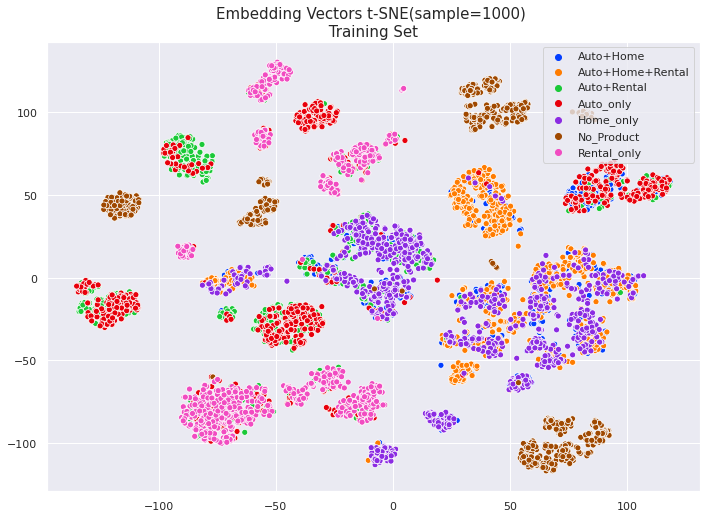

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(train_embedding[:,0], train_embedding[:,1], hue=prod_sample_train.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE(sample=1000) \n Training Set ",fontsize=15)

In [37]:
a,b=np.unique(prod_sample_val,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Validation Set ')

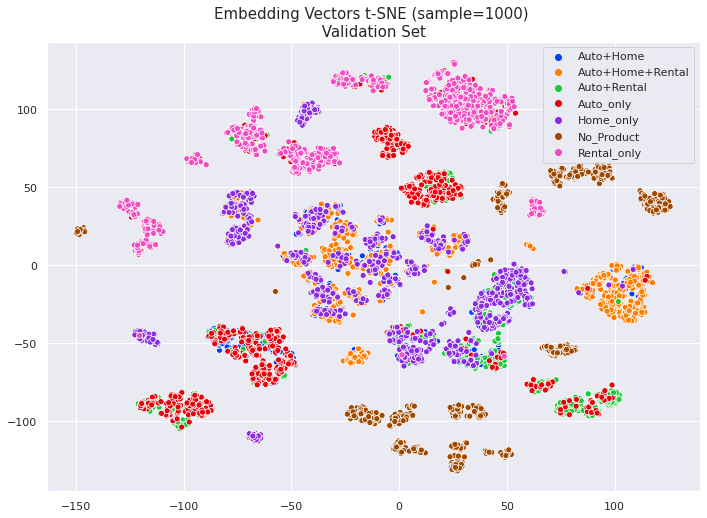

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(val_embedding[:,0], val_embedding[:,1], hue=prod_sample_val.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Validation Set ",fontsize=15)

In [39]:
a,b=np.unique(prod_sample_test,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Test Set ')

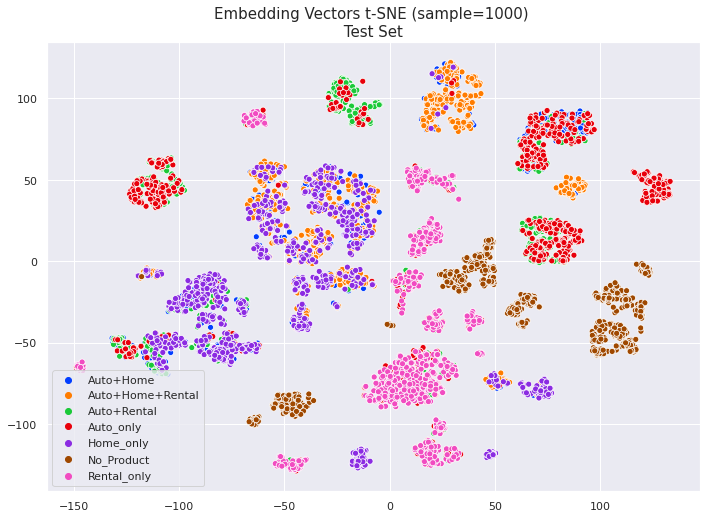

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(test_embedding[:,0], test_embedding[:,1], hue=prod_sample_test.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Test Set ",fontsize=15)